In [2]:
# Data taken from
# https://survstat.rki.de/Content/Query/Create.aspx

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv("campylobacter_data.csv", encoding="utf-16", sep="\s+")
df = df.drop(columns=["Total", "Unnamed: 0"])
df = df.drop(index=df.index[0])
df.values.flatten().tolist()
campy = pd.DataFrame([x for x in df.values.flatten().tolist() if pd.notna(x)])

<>:8: SyntaxWarning: invalid escape sequence '\s'
<>:8: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_9465/1132178785.py:8: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_csv("campylobacter_data.csv", encoding="utf-16", sep="\s+")


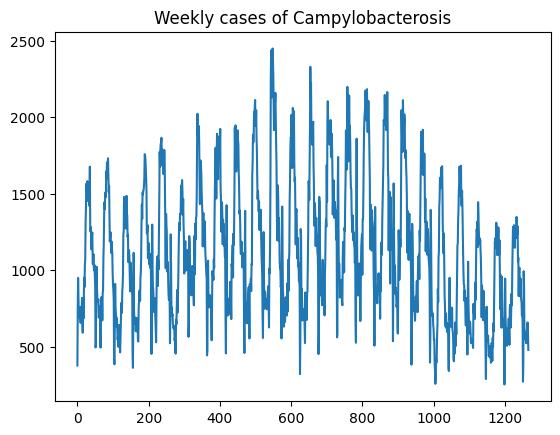

In [3]:
plt.plot(campy)
plt.title("Weekly cases of Campylobacterosis")
plt.show()

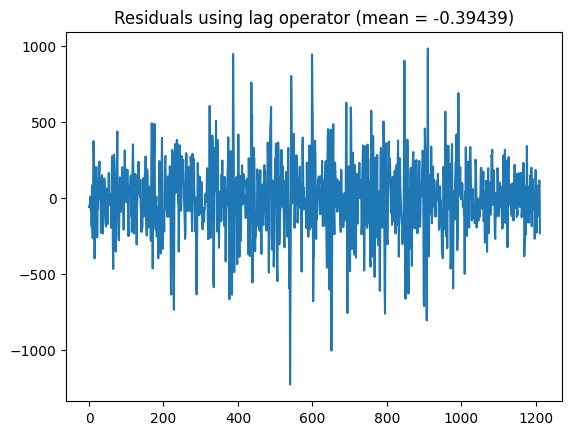

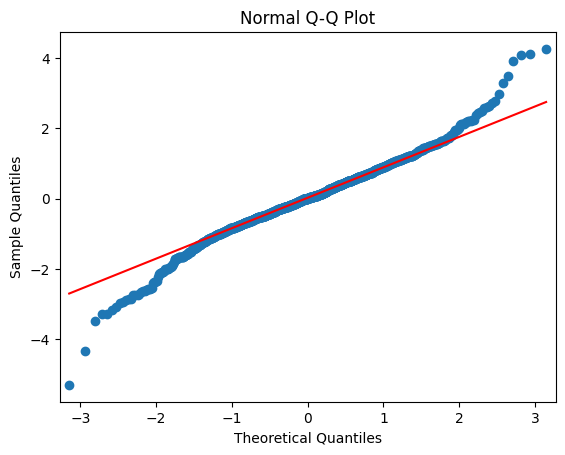

In [31]:

from statsmodels.api import qqplot
decomp1 = campy.diff(52)
decomp2 = decomp1.diff(3).dropna()

campy_clean = np.array(decomp2.values.flatten().tolist())

plt.plot(campy_clean)
plt.title(f"Residuals using lag operator (mean = {np.mean(campy_clean):.5f})")
plt.show()

qqplot(campy_clean, line="q", fit=True)
plt.title("Normal Q-Q Plot")
plt.show()

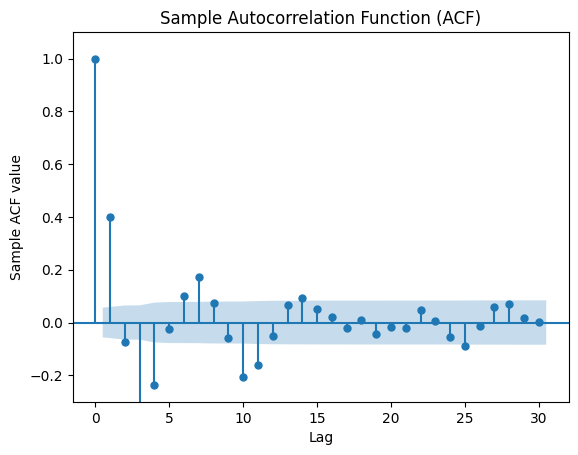

In [5]:
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf

# Plot the autocorrelation function using statsmodels
plot_acf(campy_clean, lags=30)
plt.title("Sample Autocorrelation Function (ACF)")
plt.xlabel("Lag")
plt.ylabel("Sample ACF value")
plt.ylim([-0.3, 1.1])
plt.show()

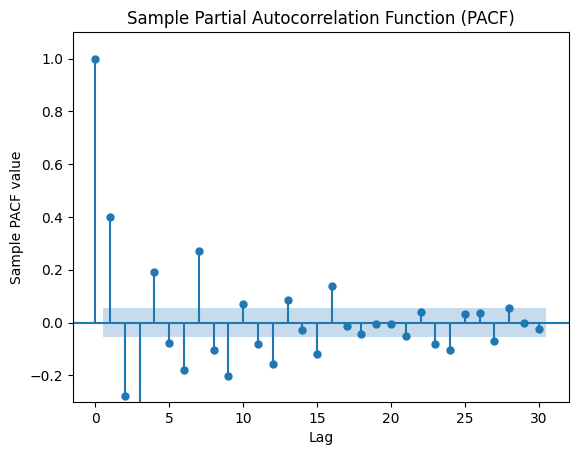

In [6]:
from statsmodels.graphics.tsaplots import plot_pacf

# Plot the partial autocorrelation function
plot_pacf(campy_clean, lags=30, method='ywmle')
plt.title("Sample Partial Autocorrelation Function (PACF)")
plt.xlabel("Lag")
plt.ylabel("Sample PACF value")
plt.ylim([-0.3, 1.1])
plt.show()

In [7]:
import statsmodels.tsa.arima.model as ARIMA

p = 15
q = 10

aics = np.zeros((p, q))

for ar in range(p):
    for ma in range(q):
        model = ARIMA.ARIMA(campy_clean, order=(ar, 0, ma))
        results = model.fit()
        aics[ar, ma]  = results.aicc

data = aics

# Define AR and MA ranges
p_range = range(data.shape[0])  # AR terms
q_range = range(data.shape[1])  # MA terms

# Create DataFrame for nice formatting
df = pd.DataFrame(data, index=[f"AR({p})" for p in p_range], columns=[f"MA({q})" for q in q_range])

# Print the table
print("AIC Table (rows: AR order, columns: MA order):\n")
print(df)

# Find and print the minimum value and its location
min_val = df.min().min()
min_loc = df.stack().idxmin()

print(f"\nMinimum value: {min_val:.4f} at {min_loc}")

KeyboardInterrupt: 

/home/anza/PyCharmMiscProject/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


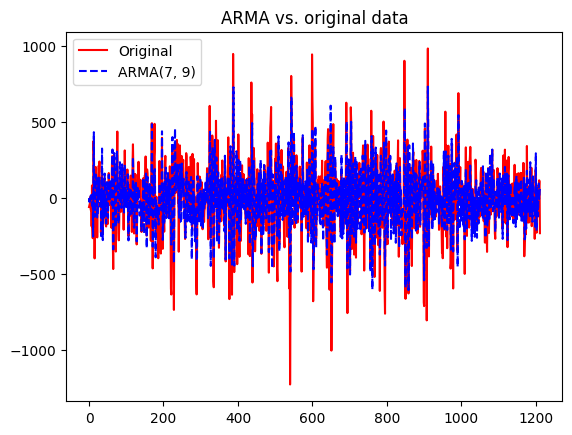

In [10]:

import statsmodels.tsa.arima.model as ARIMA

model = ARIMA.ARIMA(campy_clean, order=(7, 0, 9))
results = model.fit()

plt.plot(campy_clean, "r", label="Original")
plt.plot(results.fittedvalues, "b--", label="ARMA(7, 9)")
plt.legend()
plt.title("ARMA vs. original data")
plt.show()

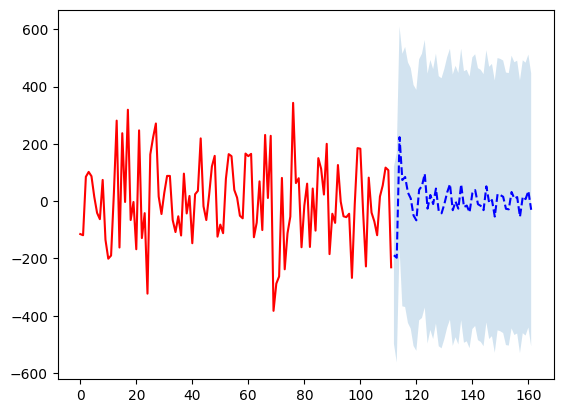

In [36]:
forcast_data = results.get_forecast(50)
conf = forcast_data.conf_int()

lower_conf = conf[:, 0]
upper_conf = conf[:, 1]

a = len(campy_clean[1100:])
b = len(forcast_data.predicted_mean)

plt.plot(range(a), campy_clean[1100:], "r", label="Original")
plt.plot(range(a, a+b), forcast_data.predicted_mean, "b--", label="Forecast")
plt.fill_between(range(a, a+b), lower_conf, upper_conf, label="Confidence Interval", alpha=.2)
plt.show()


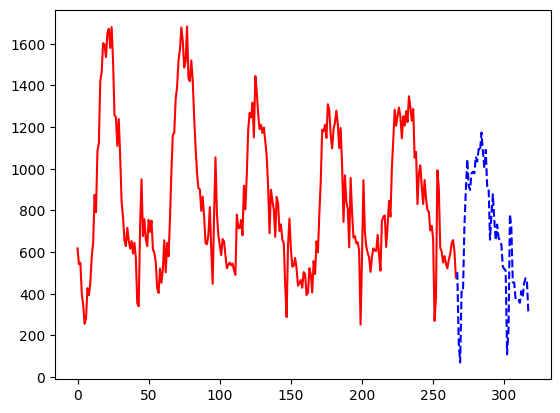

In [37]:
last_decomp1 = decomp1.iloc[-1].values[0]

forecast_level1 = np.r_[last_decomp1, forcast_data.predicted_mean].cumsum()
forecast_level1_l = np.r_[last_decomp1, lower_conf].cumsum()
forecast_level1_u = np.r_[last_decomp1, upper_conf].cumsum()

seasonal_base = campy.values[-52:].flatten()
reconstructed_forecast = forecast_level1 + seasonal_base[-len(forecast_level1):]

dat1 = campy.values.flatten()
dat2 = reconstructed_forecast

c = len(dat1[1000:])
d = len(dat2)

plt.plot(range(c), dat1[1000:], "r", label="Original")
plt.plot(range(c, c+d), dat2, "b--", label="Forecast")
plt.show()